In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import lightgbm as lgb

In [ ]:
import os
import pandas as pd

In [ ]:
import kagglehub
uber_fares_dataset_path = kagglehub.dataset_download('yasserh/uber-fares-dataset')

# Find the CSV file within the downloaded directory
csv_file_path = None
for filename in os.listdir(uber_fares_dataset_path):
    if filename.endswith('.csv'):
        csv_file_path = os.path.join(uber_fares_dataset_path, filename)
        break #stop after finding the first one.

if csv_file_path:
    df = pd.read_csv(csv_file_path)
    print(df.head()) #or any other operation on the df
else:
    print("CSV file not found in the downloaded directory.")

   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         

In [ ]:
# Drop unnecessary columns
df.drop(columns=["Unnamed: 0", "key"], inplace=True)

# Convert pickup_datetime to datetime format
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors='coerce', utc=True)

# Drop rows with missing values
df.dropna(inplace=True)

# Filter out incorrect fare values (negative and unrealistically high fares)
df = df[(df["fare_amount"] > 0) & (df["fare_amount"] < 500)]

# NYC Valid Coordinates (Rough Boundaries)
NYC_LAT_RANGE = (40.5, 41.5)
NYC_LONG_RANGE = (-74.5, -72.5)

# Remove out-of-bound coordinates
df = df[
    (df["pickup_latitude"].between(*NYC_LAT_RANGE)) &
    (df["pickup_longitude"].between(*NYC_LONG_RANGE)) &
    (df["dropoff_latitude"].between(*NYC_LAT_RANGE)) &
    (df["dropoff_longitude"].between(*NYC_LONG_RANGE))
]

# Drop duplicate rows
df.drop_duplicates(inplace=True)

print(f"Shape after preprocessing: {df.shape}")

Shape after preprocessing: (195760, 7)


In [ ]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5


In [ ]:
# Extract time-based features
df["year"] = df["pickup_datetime"].dt.year
df["month"] = df["pickup_datetime"].dt.month
df["day"] = df["pickup_datetime"].dt.day
df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
df["hour"] = df["pickup_datetime"].dt.hour

# Additional categorical features
df["is_rush_hour"] = df["hour"].apply(lambda x: 1 if (7 <= x <= 9 or 16 <= x <= 19) else 0)
df["is_night"] = df["hour"].apply(lambda x: 1 if (x < 6 or x > 22) else 0)
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

# Calculate Haversine distance (great-circle distance between points)
from geopy.distance import great_circle

def haversine_distance(lat1, lon1, lat2, lon2):
    return great_circle((lat1, lon1), (lat2, lon2)).km

df["distance_km"] = df.apply(lambda row: haversine_distance(
    row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)

df = df[df["distance_km"] > 0]  # Removing zero-distance rides

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


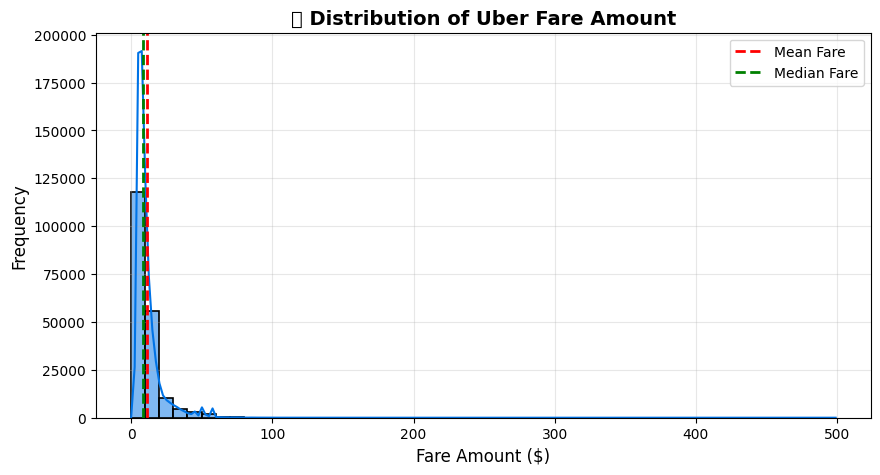

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df["fare_amount"], bins=50, kde=True, color="#0073e6", edgecolor="black", linewidth=1.2)
plt.axvline(df["fare_amount"].mean(), color="red", linestyle="dashed", linewidth=2, label="Mean Fare")
plt.axvline(df["fare_amount"].median(), color="green", linestyle="dashed", linewidth=2, label="Median Fare")
plt.title("📊 Distribution of Uber Fare Amount", fontsize=14, fontweight="bold")
plt.xlabel("Fare Amount ($)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
from folium.plugins import HeatMap

# Create a base map
nyc_map = folium.Map(location=[40.75, -74.00], zoom_start=11)

# Add pickup locations as a heatmap
heat_data = list(zip(df['pickup_latitude'], df['pickup_longitude']))
HeatMap(heat_data[:10000]).add_to(nyc_map)  # Limit to 10k points for speed

# Show the map
nyc_map

<ipython-input-12-e978d7b7a775>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_rush_hour", y="fare_amount", data=df, palette=["#FF4500", "#32CD32"], width=0.6)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


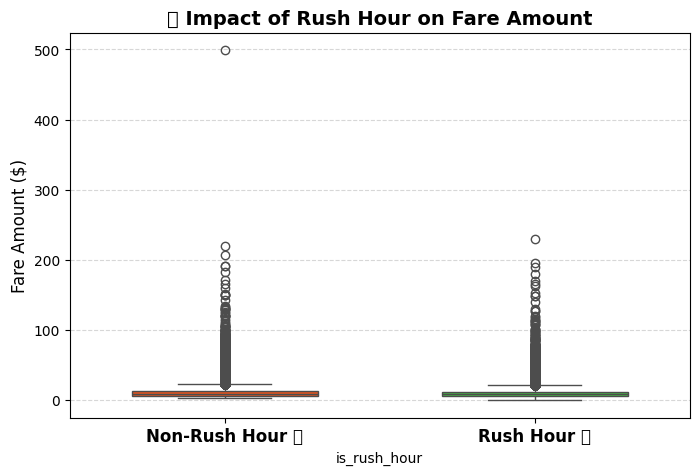

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="is_rush_hour", y="fare_amount", data=df, palette=["#FF4500", "#32CD32"], width=0.6)
plt.xticks([0, 1], ["Non-Rush Hour 🚗", "Rush Hour 🚦"], fontsize=12, fontweight="bold")
plt.ylabel("Fare Amount ($)", fontsize=12)
plt.title("🚕 Impact of Rush Hour on Fare Amount", fontsize=14, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


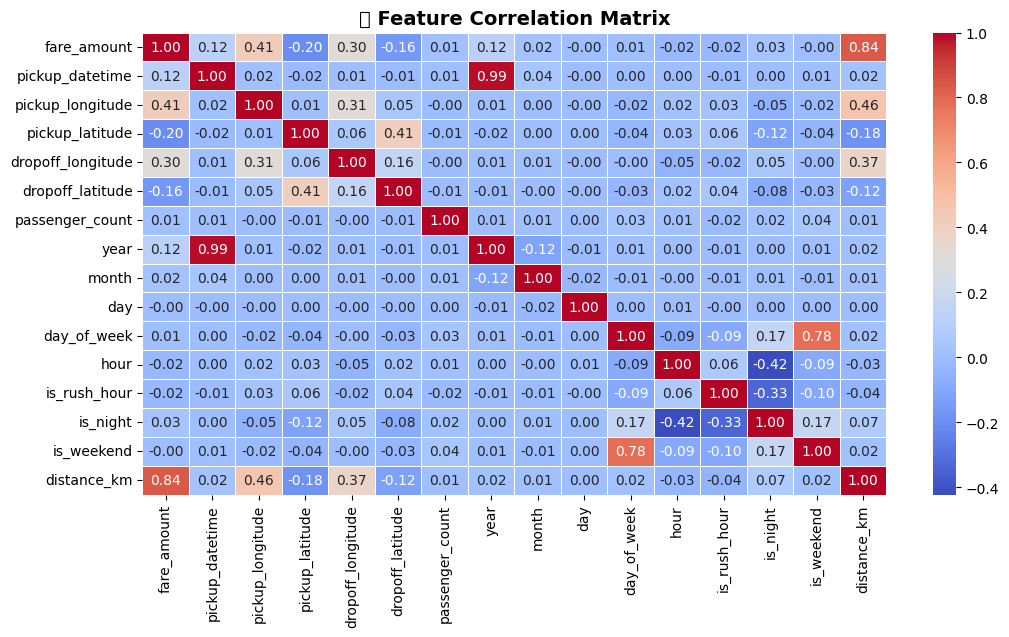

In [ ]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Set up the figure size
plt.figure(figsize=(12, 6))

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Set title
plt.title("🔗 Feature Correlation Matrix", fontsize=14, fontweight='bold')

# Display the plot
plt.show()

In [ ]:
# Selecting features and target
features = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude",
            "passenger_count", "year", "month", "day", "day_of_week", "hour",
            "is_rush_hour", "is_night", "is_weekend", "distance_km"]

X = df[features]
y = df["fare_amount"]

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - MAE: {mae_lr:.2f}, R²: {r2_lr:.2f}")

Linear Regression - MAE: 2.30, R²: 0.76


In [ ]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

poly_lr = LinearRegression()
poly_lr.fit(X_train_poly, y_train)
y_pred_poly = poly_lr.predict(X_test_poly)

mae_poly = mean_absolute_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Polynomial Regression - MAE: {mae_poly:.2f}, R²: {r2_poly:.2f}")

Polynomial Regression - MAE: 2.07, R²: 0.80


<ipython-input-17-da3e1bbaaddb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=models, y=r2_scores, palette="coolwarm", edgecolor="black", linewidth=1.5)
<ipython-input-17-da3e1bbaaddb>:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


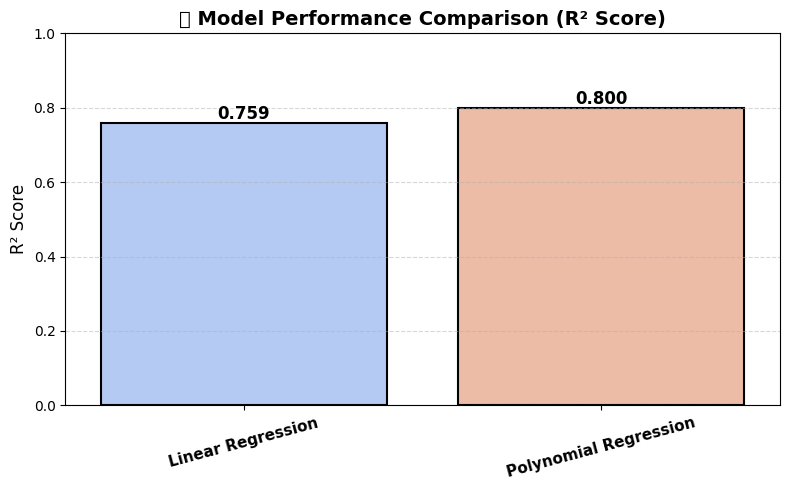

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Only two models for comparison
models = ["Linear Regression", "Polynomial Regression"]
r2_scores = [r2_lr, r2_poly]  # Make sure r2_lr and r2_poly are defined

plt.figure(figsize=(8, 5))
bars = sns.barplot(x=models, y=r2_scores, palette="coolwarm", edgecolor="black", linewidth=1.5)

# Adding text labels
for bar in bars.patches:
    bars.annotate(f"{bar.get_height():.3f}",
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha="center", va="bottom", fontsize=12, fontweight="bold", color="black")

plt.title("📈 Model Performance Comparison (R² Score)", fontsize=14, fontweight="bold")
plt.ylabel("R² Score", fontsize=12)
plt.xticks(fontsize=11, fontweight="bold", rotation=15)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


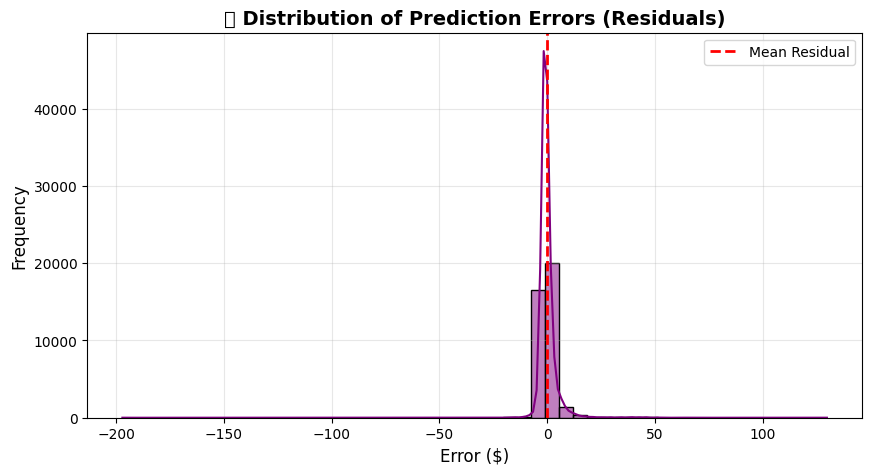

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(y_test - y_pred_lr, bins=50, kde=True, color="purple", edgecolor="black")
plt.axvline((y_test - y_pred_lr).mean(), color="red", linestyle="dashed", linewidth=2, label="Mean Residual")
plt.title("📉 Distribution of Prediction Errors (Residuals)", fontsize=14, fontweight="bold")
plt.xlabel("Error ($)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()